In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,Absorption_avg_100,Absorption_std_100,Absorption_avg_200,Absorption_std_200,median_CF,median_perm,median_MBN,median_CF_g,median_perm_g,median_pMBN_g
T_B1,12.947951,0.073112,0.000234,0.000018,0.0175,0.0042,0.001264,0.000519,4.410000e-13,4.090000e-07,...,0.000682,0.000193,0.000373,0.000094,1.1000,68.50,0.4730,NaN,NaN,NaN
T_B2,12.920068,0.077814,0.000571,0.000139,0.0240,0.0057,0.002486,0.000816,1.520000e-06,1.510000e-06,...,0.001069,0.000365,0.000874,0.000234,1.1095,66.45,0.6305,NaN,NaN,NaN
T_B3,12.932865,0.088762,0.000244,0.000030,0.0134,0.0028,0.001168,0.000555,4.270000e-13,5.640000e-07,...,0.000658,0.000246,0.000349,0.000078,1.0795,68.40,0.5765,NaN,NaN,NaN
T_B4,10.763517,0.071173,0.000379,0.000100,0.0146,0.0031,0.002084,0.000648,7.580000e-07,1.000000e-06,...,0.000921,0.000223,0.000701,0.000136,4.5140,32.90,0.5005,NaN,NaN,NaN
T_B5,12.942958,0.074808,0.000230,0.000033,0.0182,0.0040,0.001141,0.000447,3.970000e-13,4.670000e-07,...,0.000571,0.000113,0.000397,0.000088,1.4290,64.95,0.5380,NaN,NaN,NaN


## Calculating new values

In [3]:
calc_df = mc.updated_df(df, mc.measures_list, mc.errors_list)

In [4]:
calc_df.describe()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,Absorption_avg_50_UB,Absorption_avg_100_UB,backscatter_avg_UB,A_UB,B_UB,p_UB,Absorption_avg_200_UB,AUC_avg,AUC_LB,AUC_UB
count,24.000000,24.000000,16.000000,16.000000,24.000000,16.000000,24.000000,24.000000,2.400000e+01,2.400000e+01,...,16.000000,24.000000,24.000000,24.000000,24.000000,24.000000,16.000000,2.400000e+01,2.400000e+01,2.400000e+01
mean,12.444946,0.094940,0.000356,0.000058,0.022125,0.004994,0.001851,0.000611,2.139557e-07,5.654833e-07,...,0.006752,0.001458,0.022126,0.000301,0.034944,0.206003,0.000635,2.191276e+29,-3.082447e+32,3.086829e+32
std,0.882849,0.024646,0.000108,0.000037,0.005491,0.001762,0.000614,0.000220,5.191123e-07,4.960846e-07,...,0.002025,0.000318,0.005491,0.000264,0.030404,0.111222,0.000203,5.316607e+29,2.701088e+32,2.707234e+32
min,10.763517,0.071173,0.000230,0.000018,0.013400,0.002800,0.000933,0.000210,2.010000e-13,9.860000e-08,...,0.003968,0.000920,0.013401,0.000052,0.006169,0.059678,0.000425,2.058598e+23,-9.431157e+32,5.373251e+31
25%,12.114038,0.077206,0.000273,0.000028,0.018125,0.003700,0.001373,0.000445,4.260000e-13,1.262500e-07,...,0.005129,0.001205,0.018125,0.000067,0.007849,0.085463,0.000490,4.363003e+23,-3.672279e+32,6.873007e+31
50%,12.926379,0.090211,0.000340,0.000049,0.022600,0.004650,0.001747,0.000598,1.152100e-10,4.440000e-07,...,0.006472,0.001451,0.022600,0.000237,0.027637,0.213795,0.000580,1.179950e+26,-2.422169e+32,2.422169e+32
75%,12.985953,0.102029,0.000415,0.000078,0.025700,0.005825,0.002148,0.000788,9.282500e-08,6.730000e-07,...,0.008259,0.001632,0.025701,0.000359,0.041527,0.265169,0.000726,9.506884e+28,-6.861151e+31,3.676161e+32
max,13.169977,0.182199,0.000571,0.000139,0.035900,0.008700,0.003377,0.001147,2.070000e-06,1.730000e-06,...,0.010608,0.002106,0.035900,0.000921,0.105480,0.495335,0.001109,2.120038e+30,-5.360080e+31,9.434106e+32


## Scaling values

In [5]:
scaled_df = mc.scale_general(calc_df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,TEP_error_uV_C,Absorption_avg_500,Absorption_std_500,backscatter_avg,backscatter_std,Absorption_avg_50,Absorption_std_50,A,A std,...,Absorption_avg_50_UB,Absorption_avg_100_UB,backscatter_avg_UB,A_UB,B_UB,p_UB,Absorption_avg_200_UB,AUC_avg,AUC_LB,AUC_UB
T_B1,0.907738,0.017461,0.010566,0.000000,0.182222,0.237288,0.135434,0.330382,1.159420e-07,0.190266,...,0.225301,0.236882,0.182219,0.190560,0.195406,0.366148,0.061110,1.159429e-07,0.809257,0.190560
T_B2,0.896151,0.059814,1.000000,1.000000,0.471111,0.491525,0.635434,0.646362,7.342995e-01,0.865146,...,0.635241,0.813818,0.471163,0.864595,0.872421,0.490493,1.000000,7.342995e-01,0.138599,0.864595
T_B3,0.901469,0.158423,0.039918,0.098855,0.000000,0.000000,0.096154,0.368786,1.091788e-07,0.285276,...,0.000000,0.247427,0.000000,0.284956,0.288286,0.363974,0.002691,1.091795e-07,0.714843,0.284956
T_B4,0.000000,0.000000,0.436748,0.678038,0.053333,0.050847,0.470949,0.467570,3.661835e-01,0.552532,...,0.183133,0.547157,0.053354,0.556354,0.559263,0.549849,0.601457,3.661835e-01,0.445141,0.556354
T_B5,0.905663,0.032736,0.000000,0.128237,0.213333,0.203390,0.085106,0.253680,9.468600e-08,0.225818,...,0.176657,0.082841,0.213333,0.226246,0.230800,0.425646,0.088330,9.468692e-08,0.773564,0.226246


## Selecting sub samples

In [6]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(calc_df)

In [7]:
tube_scaled, pipe_scaled, tube_wo_blind_scaled, tube_blind_scaled = mc.get_subsample_df(scaled_df)

In [8]:
short_scaled_df = scaled_df.copy().loc[:,mc.without_std_g_list]
tube_scaled_short, pipe_scaled_short, \
tube_wo_blind_scaled_short, tube_blind_scaled_short = mc.get_subsample_df(short_scaled_df)

# Clustering

## Elbow method

In [15]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

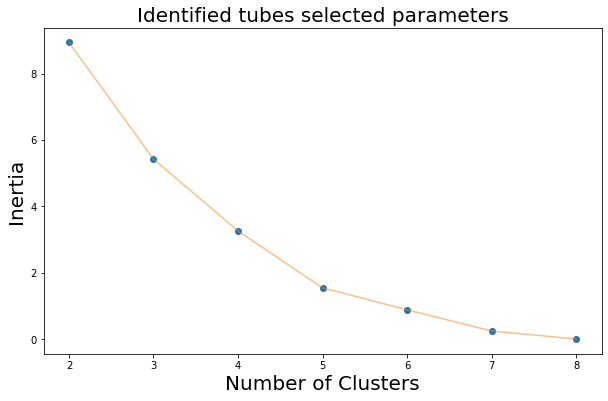

In [25]:
# tubes
plot_elbow_kmeans(tube_wo_blind_scaled_short, title='Identified tubes selected parameters')

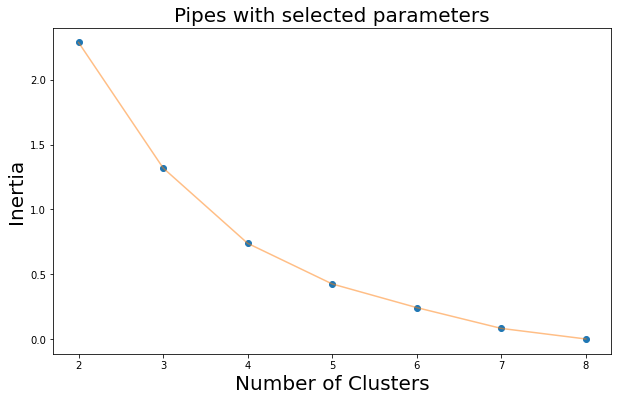

In [21]:
# pipes
plot_elbow_kmeans(pipe_scaled_short, title='Pipes with selected parameters')

## Auto find K
Source: https://jtemporal.com/kmeans-and-elbow-method/

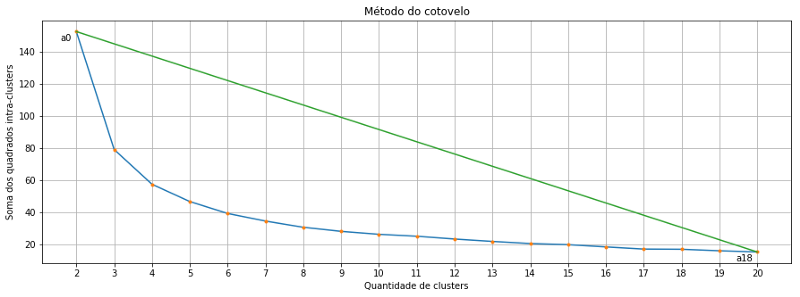

In [24]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

In [24]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_wo_blind_scaled_short)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number fo cluster =', n)

Number fo cluster = 5


In [60]:
tube_wo_blind_scaled_short.iloc[:, np.r_[0, 2:4, 6:9,-1]]

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,median_CF,median_perm,median_MBN,labels
T_AR,0.907355,0.200000,0.132570,0.151024,0.287488,0.449731,0
T_N,0.017291,0.528889,0.898118,0.945880,0.004965,0.445894,1
T_N_T,0.893838,0.604444,0.370295,0.121039,0.340616,0.934766,2
T_T,0.901396,0.248889,0.277414,0.119576,0.339623,0.386032,0
T_OT,0.638162,0.528889,0.242635,0.286689,0.273585,0.203377,0
T_FF,0.873586,0.297778,1.000000,0.013896,0.694141,1.000000,4
T_HAZ,0.102538,0.097778,0.310966,1.000000,0.008937,0.035303,3
T_HAZ_T,0.918599,0.413333,0.186989,0.116772,0.366435,0.297007,0


In [68]:
def plot_kmeans(df, k, range_col):
    '''
    Scatter plot
    Args:
    - df : scaled pandas dataframe
    - range_col : np.r_[range of column wanted]
    return plot
    '''
    model = KMeans(n_clusters = k, random_state= 42)
    model.fit(df) 
    labels = model.predict(df)
    print(labels)
    df['labels'] = labels
    sns.pairplot(df.iloc[:, range_col], hue='labels')

[0 1 2 0 0 4 3 0]


/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: 

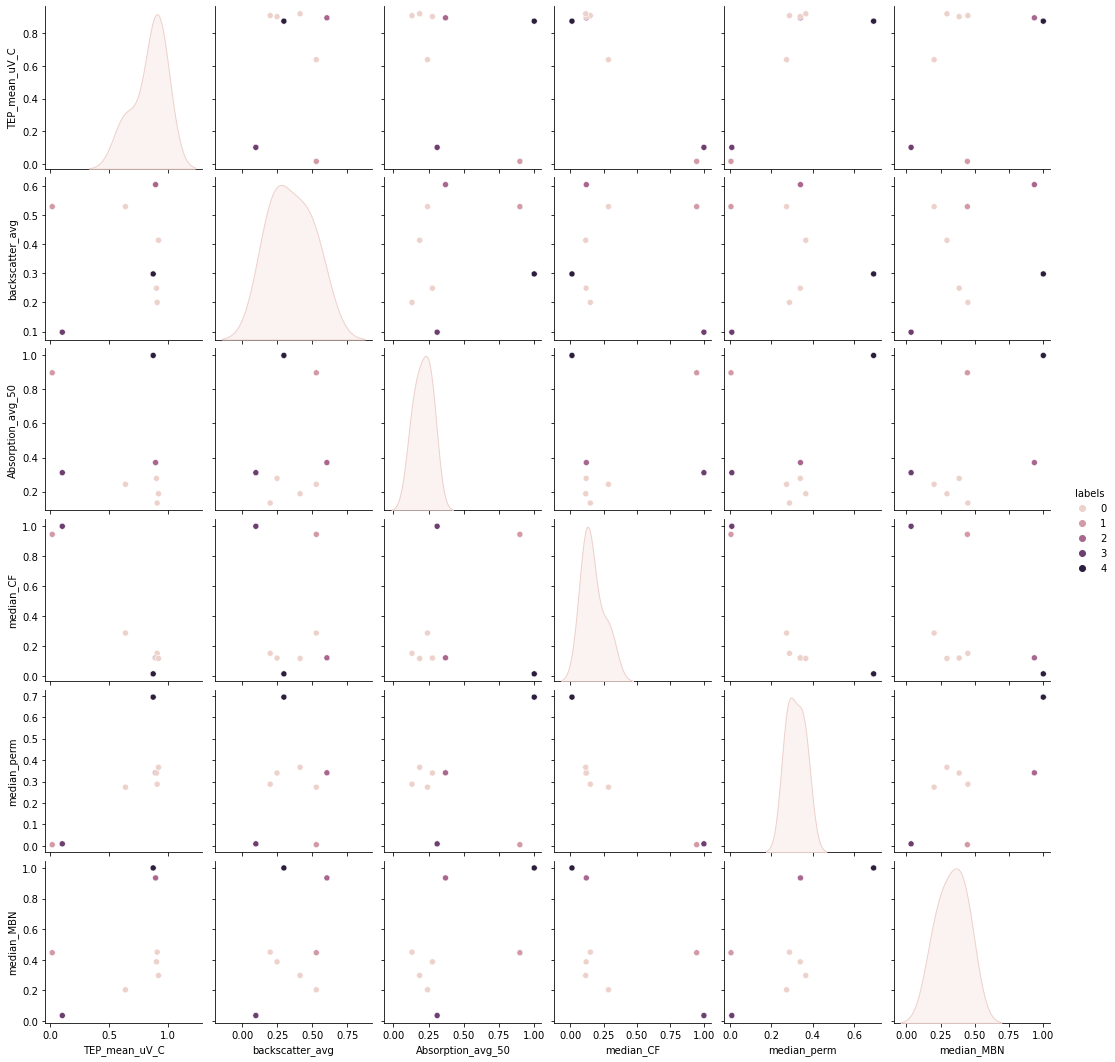

In [70]:
plot_kmeans(tube_wo_blind_scaled_short, 5, np.r_[0, 2:4, 6:9,-1] )

[2 2 2 1 1 1 0 3]


/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: 

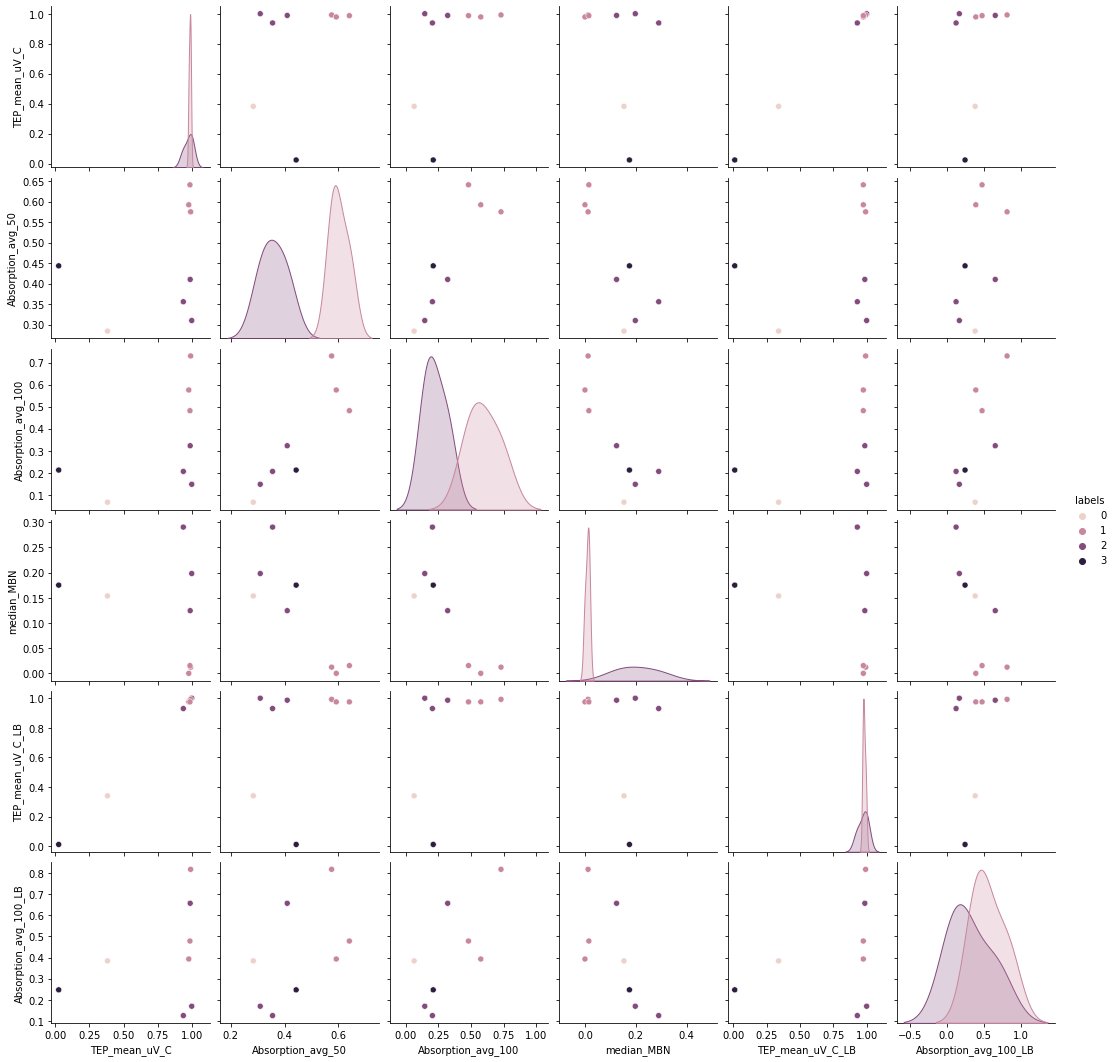

In [72]:
plot_kmeans(pipe_scaled_short, 4, np.r_[0, 2:4, 6:9,-1] )